# Part II - (Prosper Loan Data)
## by (Abas Omar)

## Investigation Overview

- I wanted to find what variables are associated most with successful loan. 
- Employment status, delinquency, homeownership, income, debt to income ratio, which factors into success and how or by how much.


## Dataset Overview
- We have approximately 111 000 loans, starting from the end of 2004 over a period of 9 years.
- Few thousand datapoints were removed as well as dozens of variables as we reduced them from 81 to 22.
- APR - Annual Percent Rate
- DTI - debt to income ratio
- Rating - Prosper Rating Alpha
- We want to look at how these relate to some of the other variables in gaining insight into the borrower.

In [4]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loan_df = pd.read_csv('data/loan_data_master.csv')

In [11]:
sns.reset_defaults()

In [68]:
default_color = sns.color_palette()[0]
sns.set(style="whitegrid", rc={"figure.figsize":(10, 6), 'axes.grid': False, 'axes.titlesize':20, 'axes.labelsize':16,}, font_scale=1.2)

In [23]:
income_df = loan_df.groupby(['rating_alpha']).agg({'stated_income': [lambda x:np.mean(x)]}).reset_index()
income_df = pd.DataFrame(income_df.values, columns = ['Rating', 'Income'])#.sort_values(by='Income', ascending=False)
employment_df = loan_df.groupby(['rating_alpha']).agg({'employment_duration': [lambda x:np.mean(x)]}).reset_index()
employment_df = pd.DataFrame(employment_df.values, columns = ['Rating', 'Employment Duration'])

In [9]:
def set_categorical(df):
    ordinal_dict = {'past_due': ['1-15', '16-30', '31-60', '61-90', '91-120', '>120'],
                    'rating_alpha':['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
                   }
    nominal_dict = {'category': [1, 0, 7, 2, 3, 6, 4, 13, 15, 18, 14, 20, 19, 5, 16, 11, 8, 10, 9,
                12, 17],
                    'status': ['Current', 'Completed', 'Chargedoff', 'Defaulted']
                   }
    
    t_past_due = pd.CategoricalDtype(categories=ordinal_dict['past_due'], ordered=True)
    t_rating_alpha = pd.CategoricalDtype(categories=ordinal_dict['rating_alpha'], ordered=True)
    t_category = pd.CategoricalDtype(categories=nominal_dict['category'], ordered=False)
    t_status = pd.CategoricalDtype(categories=nominal_dict['status'], ordered=False)
    
    df.past_due = df.past_due.astype(t_past_due)
    df.rating_alpha = df.rating_alpha.astype(t_rating_alpha)
    df.category = df.category.astype(t_category)
    df.status = df.status.astype(t_status)
    return df
def convert_type(df):
    df = set_categorical(df)
    df.start_date = pd.to_datetime(df.start_date)
    df.closed_date = pd.to_datetime(df.closed_date)
    df[['delinquencies','credit_lines', 'employment_duration']] = df[['delinquencies','credit_lines', 'employment_duration']].convert_dtypes()
    return df
loan_df = convert_type(loan_df)

## Loan status for Prosper Loans
- We have approximately 111 000 loans, starting from the end of 2004 over a period of 9 years.
- More than half are loans that are currently ongoing.
- Nearly 40 000 are completed with 11500 being chargedoff and just under 5000 defaulted.

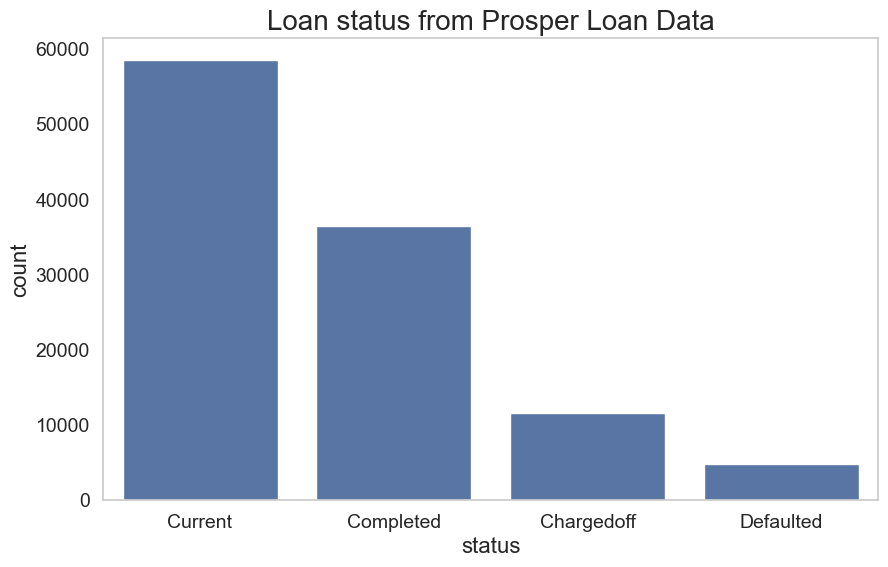

In [69]:
sns.countplot(data = loan_df, x='status', color=default_color);
plt.title('Loan status from Prosper Loan Data')
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

## Rating vs Income and Employment

- Starting from High Risk (HR) to AA the mean income of the borrower nearly doubles.
- High income borrowers tend to be in better financial state and are capable of paying loans at higher rate.
- Surprisingly the employment duration doesn't have this same trend across the rating ladder.
- Looking at it closer we can see how this would favor borrowers who have been working for decades regardless of their financial stability and ability to pay back their loans. And it would disadvantage younger people who are looking to borrow money.


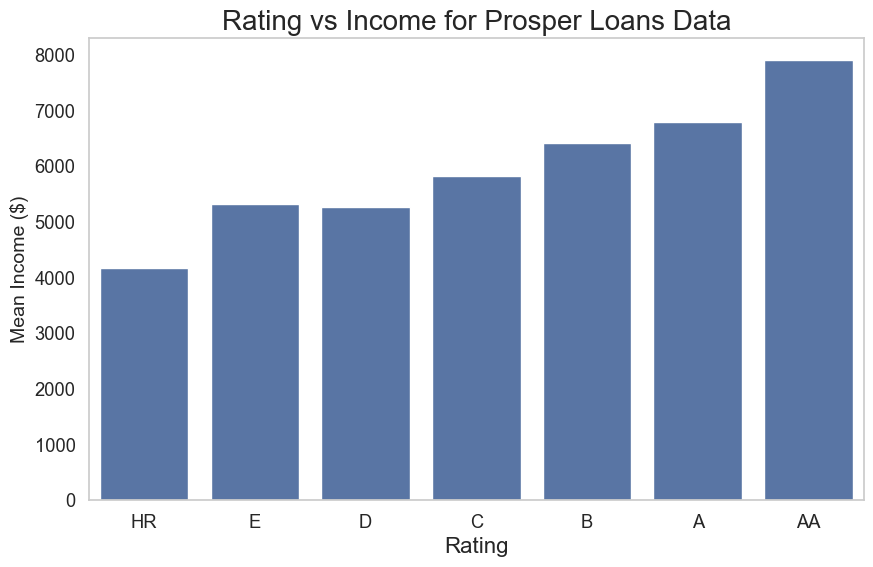

In [70]:
fig, ax = plt.subplots(nrows=1, figsize = [10,6])

sns.barplot(data=income_df, x='Rating', y='Income', color=default_color, ax = ax);
ax.set_title('Rating vs Income for Prosper Loans Data');
ax.set_ylabel('Mean Income ($)', fontsize=14);

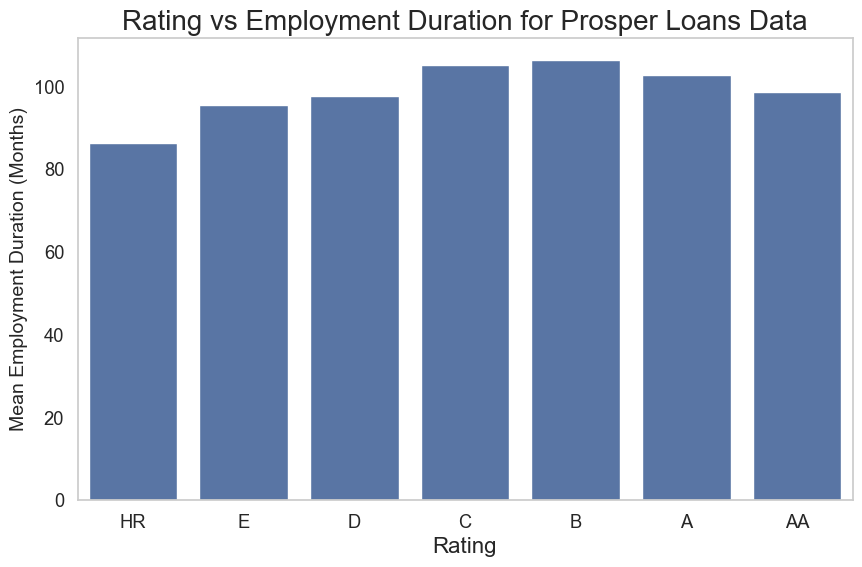

In [71]:
fig, ax = plt.subplots(nrows=1, figsize = [10,6])
sns.barplot(data=employment_df, x='Rating', y='Employment Duration', color=default_color, ax = ax);
ax.set_title('Rating vs Employment Duration for Prosper Loans Data');
ax.set_ylabel('Mean Employment Duration (Months)', fontsize=14);

## Success and homeownership rate
- As the rating increases we see a large increase in the rate of success for loans.
- Success rate increases from 57% for HR to 94.78% for AA rated borrowers.
- We also see that above D rating the rate of homeownership increases, going from 52% at C to 74% in AA.

In [27]:
success_df = loan_df.groupby(['rating_alpha', 'success']).size().reset_index(name='count')
success_df = success_df.pivot(index = 'rating_alpha', columns = 'success', values = 'count').reset_index()
success_df['success_rate'] = success_df[True]/(success_df[False]+success_df[True])

homeowner_df = loan_df.groupby(['rating_alpha', 'is_homeowner']).size().reset_index(name='count')
homeowner_df = homeowner_df.pivot(index = 'rating_alpha', columns = 'is_homeowner', values = 'count').reset_index()
homeowner_df['homeownership_rate'] = homeowner_df[True]/(homeowner_df[False]+homeowner_df[True])

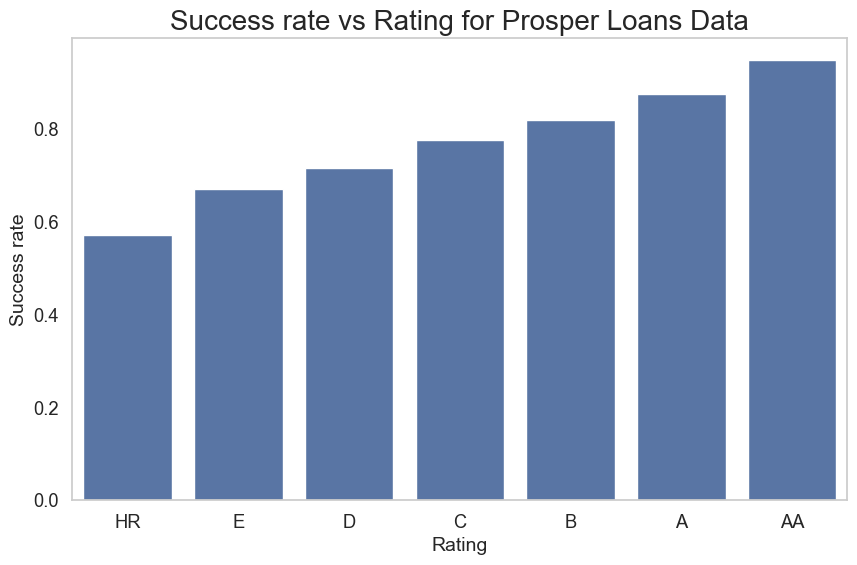

In [79]:
fig, ax = plt.subplots(nrows=1, figsize = [10,6])
sns.barplot(data=success_df, x='rating_alpha', y='success_rate', color=default_color, ax = ax);
ax.set_title('Success rate vs Rating for Prosper Loans Data');
ax.set_xlabel('Rating', fontsize=14);
ax.set_ylabel('Success rate', fontsize=14);


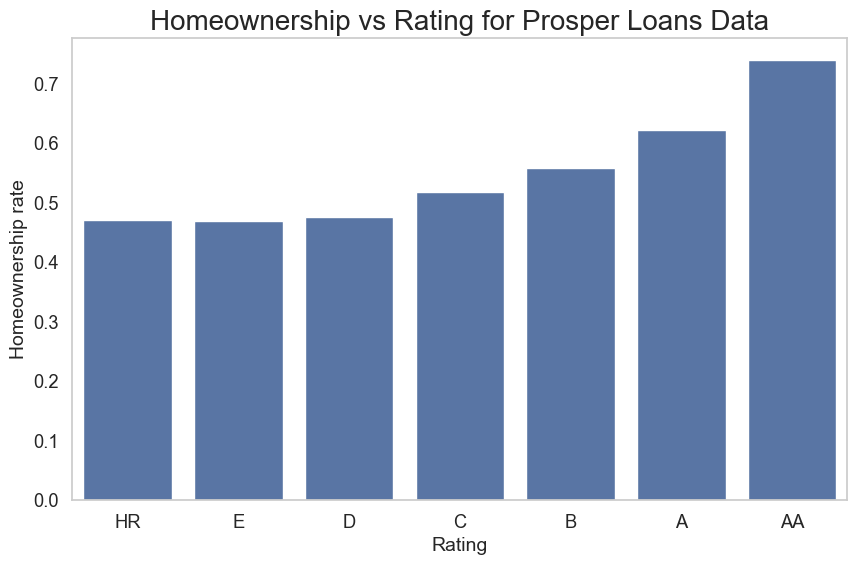

In [80]:
fig, ax = plt.subplots(nrows=1, figsize = [10,6])

sns.barplot(data=homeowner_df, x='rating_alpha', y='homeownership_rate', color=default_color, ax = ax);
ax.set_title('Homeownership vs Rating for Prosper Loans Data');
ax.set_ylabel('Homeownership rate', fontsize=14);
ax.set_xlabel('Rating', fontsize=14);

## Delinquency, Loan amount and APR
- Delinquencies go down with rating, stated otherwise, people who are delinquent get rating downgrades.
- Loan amount increases with ratings as lenders are more trusting of them.
- There is also the much lower APR on account of reduced risk, making it viable to go for bigger loans.



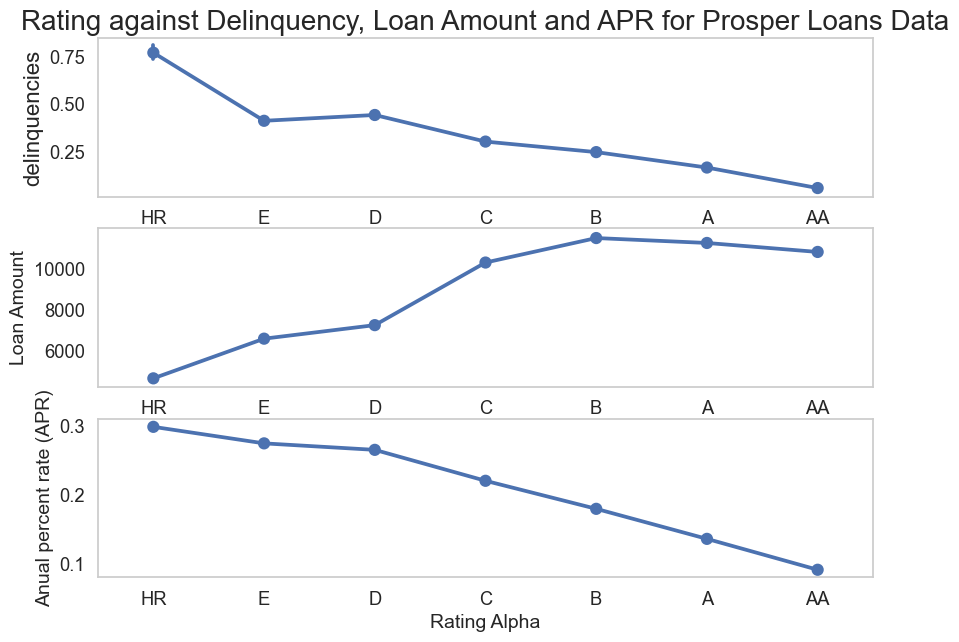

In [81]:
fig, ax = plt.subplots(nrows=3, figsize = [10,7])

sns.pointplot(x='rating_alpha', y='delinquencies', data=loan_df.dropna(subset=['delinquencies']), estimator=np.mean, ax = ax[0]);
sns.pointplot(x="rating_alpha", y="loan_amount", data=loan_df.dropna(subset=['rating_alpha']), estimator=np.mean, ax = ax[1]);
sns.pointplot(x="rating_alpha", y="apr", data=loan_df.dropna(subset=['rating_alpha']), estimator=np.mean, ax = ax[2]);
ax[0].set_title('Rating against Delinquency, Loan Amount and APR for Prosper Loans Data');
ax[0].set_xlabel('', fontsize=14);
ax[1].set_xlabel('', fontsize=14);
ax[1].set_ylabel('Loan Amount', fontsize=14);
ax[2].set_ylabel('Anual percent rate (APR)', fontsize=14);
ax[2].set_xlabel('Rating Alpha', fontsize=14);

## Delinquency, Loan amount and APR
- There are more investors in failed loans than successful ones given the same rating.
- It's because of the loan amounts, number of investors increases with the size of the loan.
- Failed loans tend to be bigger loans, holding rating constant.



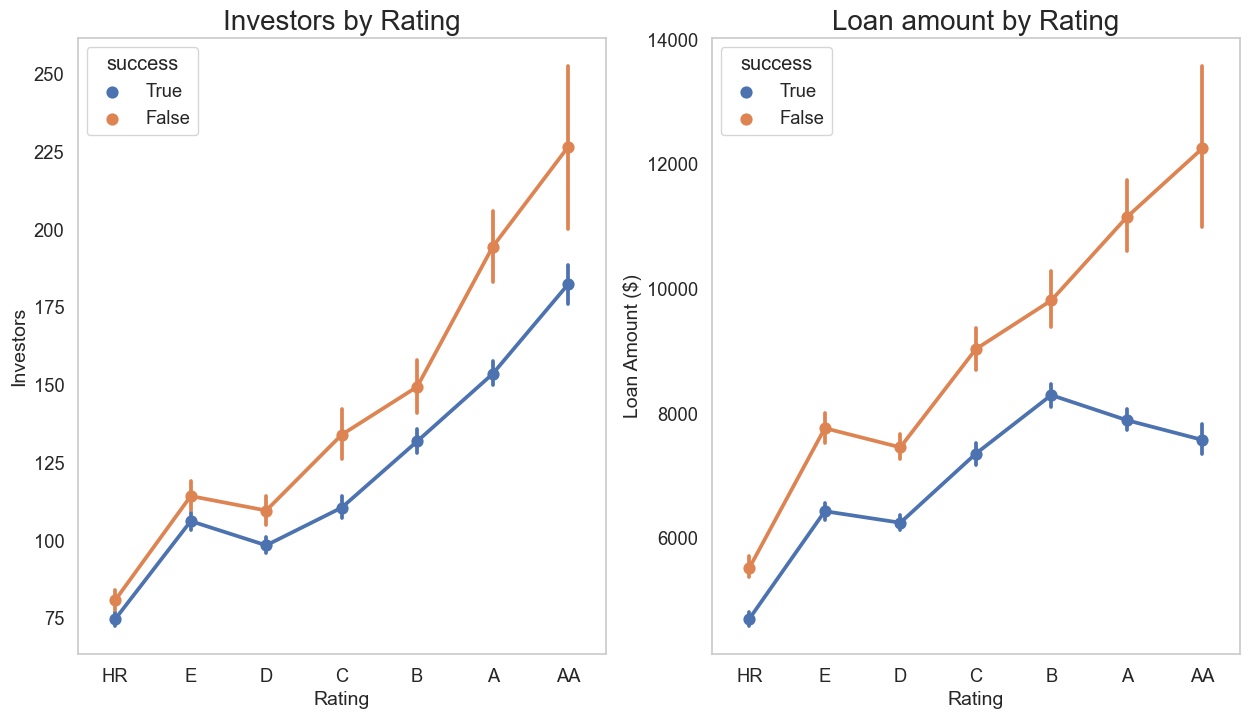

In [75]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = [15,8])
sns.pointplot(x ='rating_alpha', y ='investors', hue = 'success', data = loan_df, kind='point', ax=ax[0]);
sns.pointplot(x ='rating_alpha', y ='loan_amount', hue = 'success', data = loan_df, kind='point', ax=ax[1]);
ax[0].set_title('Investors by Rating');
ax[1].set_title('Loan amount by Rating');

ax[0].set_xlabel('Rating', fontsize=14);
ax[1].set_xlabel('Rating', fontsize=14);
ax[0].set_ylabel('Investors', fontsize=14);
ax[1].set_ylabel('Loan Amount ($)', fontsize=14);

### Conclusion
- Delinquency results in lower rating, which leads to higher APR and more expensive loans.
- Good financial behavior is rewarded with lower APR.
- Income is a good indicator of success, and so is homeownership.

In [ ]:
!jupyter nbconvert <Part_II_Filename>.ipynb --to slides --post serve --no-input --no-prompt